In [34]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

In [9]:
def perform_adf_test(series):
    result = adfuller(series)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])

# Original Series

In [10]:
ts = pd.read_csv("data/original_series.csv")
ts.index = np.arange(1, len(ts) + 1)

Text(0, 0.5, 'Views')

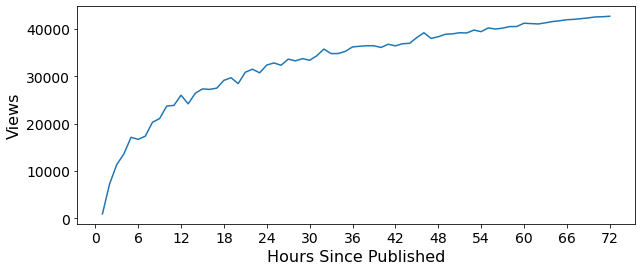

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(ts)

plt.xticks(np.arange(0, 78, 6), fontsize=14)
plt.xlabel("Hours Since Published", fontsize=16)

plt.yticks(np.arange(0, 50000, 10000), fontsize=14)
plt.ylabel("Views", fontsize=16)

# Original Series: $v_t$

# (1) Normalize ($v_t \rightarrow n_t$): $n_t = \frac{v_t - \mu}{\sigma}$

# (2) Exponentiate ($n_t \rightarrow e_t$): $e_t = e^{n_t}$

# (3) First Difference ($e_t \rightarrow d_t$): $d_t = e_t - e_{t-1}$

# $d_t = e^{\frac{v_t - \mu}{\sigma}} - e^{\frac{v_{t-1} - \mu}{\sigma}}$

# ------------------------------------------------------------

# (1) Normalize

In [12]:
mu = np.mean(ts).iloc[0]
sigma = np.std(ts).iloc[0]

norm_ts = (ts - mu) / sigma

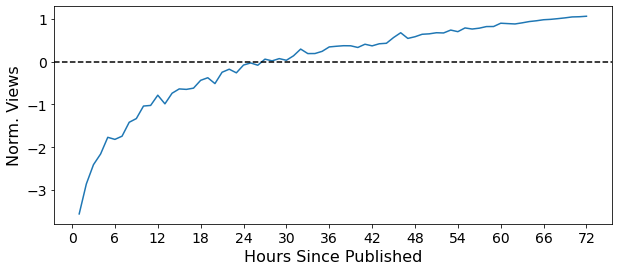

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(norm_ts)

plt.xticks(np.arange(0, 78, 6), fontsize=14)
plt.xlabel("Hours Since Published", fontsize=16)

plt.yticks(np.arange(-3, 2), fontsize=14)
plt.ylabel("Norm. Views", fontsize=16)

plt.axhline(0, color="k", linestyle="--")

# (2) Exponentiate

In [18]:
exp_ts = np.exp(norm_ts)

Text(0, 0.5, 'Exp. Norm. Views')

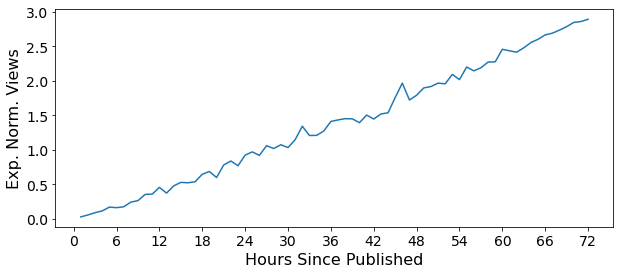

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(exp_ts)

plt.xticks(np.arange(0, 78, 6), fontsize=14)
plt.xlabel("Hours Since Published", fontsize=16)

plt.yticks(np.arange(0, 3.5, 0.5), fontsize=14)
plt.ylabel("Exp. Norm. Views", fontsize=16)

In [20]:
perform_adf_test(exp_ts)

ADF Statistic: 1.648979
p-value: 0.997997


# (3) First Difference

In [21]:
diff_ts = exp_ts.diff().dropna()

Text(0, 0.5, 'First Diff. \nExp. Norm. Views')

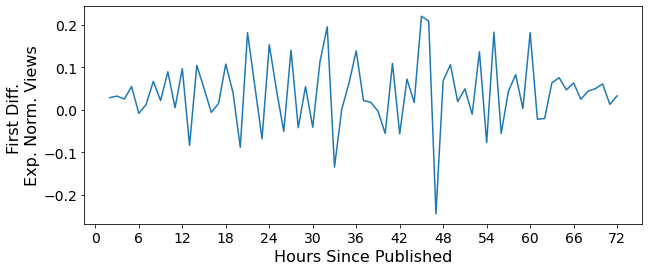

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(diff_ts)

plt.xticks(np.arange(0, 78, 6), fontsize=14)
plt.xlabel("Hours Since Published", fontsize=16)

plt.yticks(np.arange(-0.2, 0.3, 0.1), fontsize=14)
plt.ylabel("First Diff. \nExp. Norm. Views", fontsize=16)

In [23]:
perform_adf_test(diff_ts)

ADF Statistic: -4.881064
p-value: 0.000038


# Fit AR Model

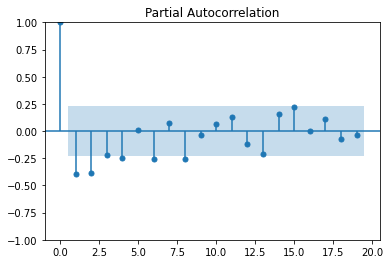

In [27]:
plot_pacf(diff_ts, method="ywm")
plt.show()

## AR(4)

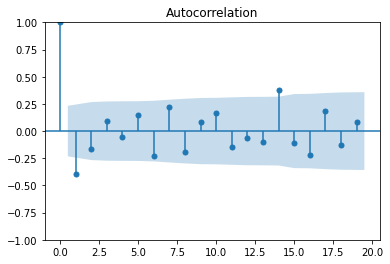

In [28]:
plot_acf(diff_ts)
plt.show()

## MA(1)

In [37]:
# create the model
model = ARIMA(diff_ts, order=(4, 0, 1))

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
model_fit = model.fit()

# Predict Out 3 Hours

In [60]:
prediction_info = model_fit.get_forecast(3).summary_frame(alpha=0.05)

predictions = prediction_info["mean"].values
lower_bound = prediction_info["mean_ci_lower"].values
upper_bound = prediction_info["mean_ci_upper"].values

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


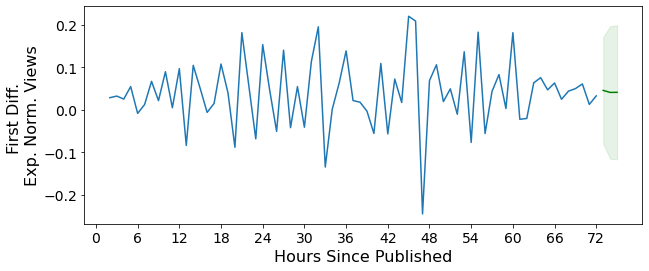

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(diff_ts)

plt.xticks(np.arange(0, 78, 6), fontsize=14)
plt.xlabel("Hours Since Published", fontsize=16)

plt.yticks(np.arange(-0.2, 0.3, 0.1), fontsize=14)
plt.ylabel("First Diff. \nExp. Norm. Views", fontsize=16)

plt.plot(np.arange(len(ts) + 1, len(ts) + 4), predictions, color="g")
plt.fill_between(
    np.arange(len(ts) + 1, len(ts) + 4), lower_bound, upper_bound, color="g", alpha=0.1
)

# Undo Transformations: ($\hat{d}_{t+1} \rightarrow \hat{v}_{t+1}$)

# $\hat{v}_{t+1} = \sigma \ln(\hat{d}_{t+1} + e^{\frac{v_t - \mu}{\sigma}}) + \mu$

In [62]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = (
        sigma * np.log(predictions[0] + np.exp((series.iloc[-1] - mu) / sigma)) + mu
    )
    orig_predictions = [first_pred]

    for i in range(len(predictions[1:])):
        next_pred = (
            sigma
            * np.log(predictions[i + 1] + np.exp((orig_predictions[-1] - mu) / sigma))
            + mu
        )
        orig_predictions.append(next_pred)

    return np.array(orig_predictions).flatten()

In [63]:
orig_preds = undo_transformations(predictions, ts, mu, sigma)
orig_lower_bound = undo_transformations(lower_bound, ts, mu, sigma)
orig_upper_bound = undo_transformations(upper_bound, ts, mu, sigma)

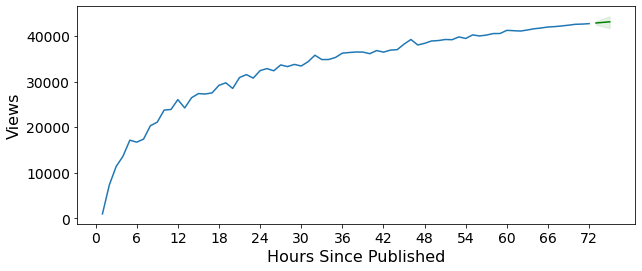

In [64]:
plt.figure(figsize=(10, 4))
plt.plot(ts)

plt.xticks(np.arange(0, 78, 6), fontsize=14)
plt.xlabel("Hours Since Published", fontsize=16)

plt.yticks(np.arange(0, 50000, 10000), fontsize=14)
plt.ylabel("Views", fontsize=16)

plt.plot(np.arange(len(ts) + 1, len(ts) + 4), orig_preds, color="g")
plt.fill_between(
    np.arange(len(ts) + 1, len(ts) + 4),
    orig_lower_bound,
    orig_upper_bound,
    color="g",
    alpha=0.1,
)

(40000.0, 45000.0)

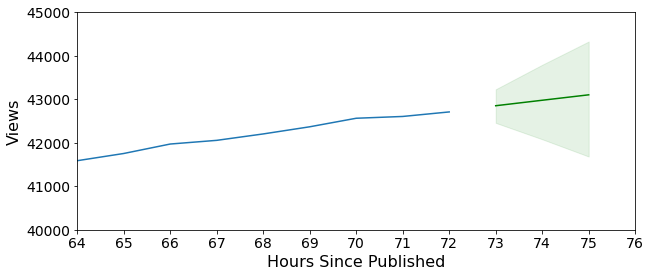

In [66]:
plt.figure(figsize=(10, 4))
plt.plot(ts)

plt.xticks(np.arange(0, 78), fontsize=14)
plt.xlabel("Hours Since Published", fontsize=16)

plt.yticks(np.arange(40000, 46000, 1000), fontsize=14)
plt.ylabel("Views", fontsize=16)

plt.plot(np.arange(len(ts) + 1, len(ts) + 4), orig_preds, color="g")
plt.fill_between(
    np.arange(len(ts) + 1, len(ts) + 4),
    orig_lower_bound,
    orig_upper_bound,
    color="g",
    alpha=0.1,
)
plt.xlim(64, 76)
plt.ylim(40000, 45000)